In [1]:
%matplotlib inline
import numpy as np
import pystan
import pandas
import matplotlib.pyplot as plt

In [2]:
rawdata = pandas.read_csv('kbay.csv')
print(rawdata)

                     Time           nsm           nlg          nsmz  \
0     2013-01-02 12:00:00  7.615127e-08  6.438968e-08  1.150254e-07   
1     2013-01-03 00:00:00  6.820777e-08  6.295397e-08  1.272876e-07   
2     2013-01-03 12:00:00  6.974728e-08  6.540762e-08  1.294311e-07   
3     2013-01-04 00:00:00  5.924295e-08  6.272898e-08  1.316977e-07   
4     2013-01-04 12:00:00  6.403061e-08  6.687172e-08  1.328638e-07   
...                   ...           ...           ...           ...   
1435  2014-12-26 00:00:00  7.335419e-08  5.064889e-08  1.372556e-07   
1436  2014-12-26 12:00:00  8.486480e-08  5.835259e-08  1.389907e-07   
1437  2014-12-27 00:00:00  7.265173e-08  5.647881e-08  1.356098e-07   
1438  2014-12-27 12:00:00  8.455670e-08  6.538912e-08  1.374827e-07   
1439  2014-12-28 00:00:00  7.213418e-08  6.344394e-08  1.336562e-07   

              nmdz          nlgz       no3      sio4           po4  
0     5.003748e-08  1.214232e-08  0.000002  0.000003  1.650181e-07  
1     5.2

In [3]:
nt = len(rawdata)
Y = rawdata.to_numpy()[:,1:].astype(np.float)

<Figure size 432x288 with 0 Axes>

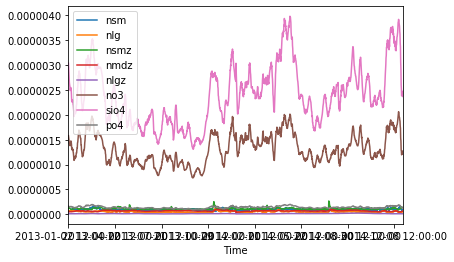

In [4]:
plt.figure()
rawdata.plot(x='Time')

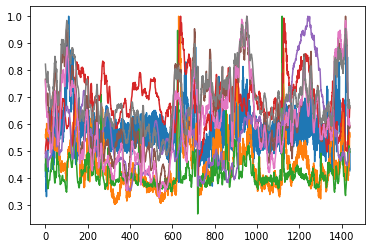

In [5]:
# Normalize the data
norms = Y.max(axis=0)
Y /= norms
plt.plot(Y)

In [6]:
p = Y.shape[1]
lags = np.arange(1,180)
corr = np.zeros((len(lags),p))
for il,l in enumerate(lags):
    for ip in range(p):
        ip1 = np.mod(ip+1,p)
        corr[il,ip] = np.corrcoef(Y[l:,ip],Y[:-l,ip1])[0,1]


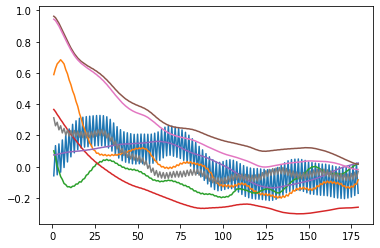

In [7]:
plt.figure()
plt.plot(lags,corr)

In [8]:
stan_code = '''data {
    int T;         //length of time series
    int p;         //number of variables
    int lags;      //number of lags to use
    matrix[T,p] Y; //matrix of modeled data; times are rows; variables are columns
    matrix[T,lags] X; //matrix of lagged data
}
parameters{
    matrix[lags,p] PHI;                  //dynamics matrix
    matrix<lower=1E-15>[p,p] sigma;        //variances
    vector<lower=1E-15>[p] epsilon;      //forcing
}
model{
    for(i in 1:T){
        real val = 0;
        for(j in 1:lags){
            val += X[i,j]*PHI[j,1];
        }
        Y[i,1] ~ normal(val + epsilon[1],sigma[1,1]);
    }
}
'''

In [9]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b5bf422d37297d42a2ca2bb4234c237e NOW.


In [10]:
Y.shape

(1440, 8)

In [11]:
# Build the lagged matrix
rng=np.s_[360:]
nlagged=Y[rng,[0,1,2,3,5,6,7]]
nt=nlagged.shape[0]

In [12]:
data = {'T':nt, 'p':1, 'lags':nlagged.shape[1], 'Y':Y[rng,4].reshape((nt,1)), 'X':nlagged}

mcmc = model.sampling(data=data,iter=2000,warmup=1000)

print(mcmc)

Inference for Stan model: anon_model_b5bf422d37297d42a2ca2bb4234c237e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
PHI[1,1]     -0.02  8.5e-4   0.05   -0.1  -0.05   -0.02   0.01   0.07   2824    1.0
PHI[2,1]     -0.71  1.2e-3   0.06  -0.82  -0.74   -0.71  -0.67   -0.6   2356    1.0
PHI[3,1]   -8.0e-3  1.4e-3   0.07  -0.15  -0.06 -7.5e-3   0.04   0.13   2638    1.0
PHI[4,1]      1.07  9.5e-4   0.05   0.97   1.04    1.07    1.1   1.17   2685    1.0
PHI[5,1]     -0.52  2.2e-3   0.11  -0.74   -0.6   -0.52  -0.44  -0.29   2699    1.0
PHI[6,1]      2.28  1.8e-3    0.1   2.09   2.21    2.28   2.34   2.48   2934    1.0
PHI[7,1]     -2.05  3.4e-3   0.16  -2.36  -2.16   -2.05  -1.94  -1.74   2246    1.0
sigma[1,1]    0.11  4.1e-5 2.4e-3    0.1   0.11    0.11   0.11   0.11   3376    1.0
epsilon[1]    0.53  1.4e-3   0.06   0.41   0.49    0.53

In [13]:
# Test the regression
phi = mcmc['PHI'].mean(axis=0)

nz = nlagged @ phi + mcmc['epsilon'][0]

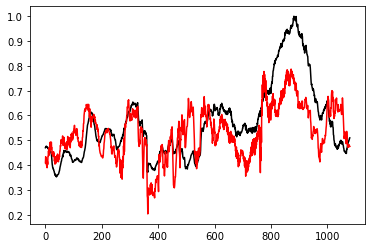

In [14]:
xx=np.arange(nt)
plt.figure()
plt.plot(xx,Y[rng,4],'k',xx,nz,'r')

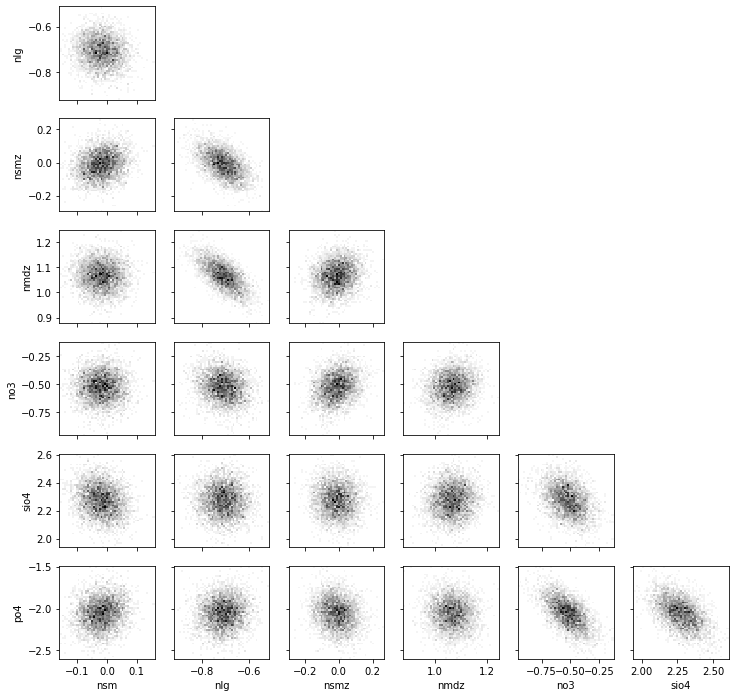

In [15]:
parameter_names = ['nsm','nlg','nsmz','nmdz','no3','sio4','po4']
mname='nlgz'
nparam = len(parameter_names)
cmap = plt.get_cmap('gray_r')

fig,axs = plt.subplots(nrows=nparam-1, ncols=nparam-1, sharex='col', sharey='row', figsize=(12,12))
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,nparam):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = parameter_names[icol]
        yname = parameter_names[irow]
        ax.hist2d(mcmc['PHI'][:,icol,0],mcmc['PHI'][:,irow,0],bins=50,cmap=cmap)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == nparam-1:
            ax.set_xlabel(xname)